https://medium.com/@manjindersingh_10145/sentiment-analysis-with-bert-using-huggingface-88e99deeec9a
https://www.kaggle.com/code/rohitgadhwar/sentiment-analysis-using-transformers

In [1]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np

tf.config.list_physical_devices('GPU')

2024-10-24 10:56:19.690297: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 10:56:19.708722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 10:56:19.727667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 10:56:19.733140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 10:56:19.746989: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# 1. Load the datasets
train_df = pd.read_csv('pt1/train.csv')
val_df = pd.read_csv('pt1/val.csv')
test_df = pd.read_csv('pt1/test.csv')

In [3]:
# 2. Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# 3. Tokenization function
def tokenize_data(data, tokenizer, max_len=128):
    return tokenizer(
        data['text'].tolist(),  # Text column from CSV
        truncation=True,
        padding=True,
        max_length=max_len,  # Set max token length for sequences
        return_tensors='tf'
    )

# 4. Tokenize the datasets
train_encodings = tokenize_data(train_df, tokenizer)
val_encodings = tokenize_data(val_df, tokenizer)
test_encodings = tokenize_data(test_df, tokenizer)

# 5. Convert labels to TensorFlow tensors
train_labels = tf.convert_to_tensor(train_df['label'].values)
val_labels = tf.convert_to_tensor(val_df['label'].values)
test_labels = tf.convert_to_tensor(test_df['label'].values)

# 6. Create TensorFlow datasets from the encodings and labels
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))

2024-10-24 10:56:27.667897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


In [4]:
# 7. Batch the datasets
BATCH_SIZE = 16
train_dataset = train_dataset.shuffle(len(train_df)).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# 8. Load pre-trained DistilBERT model with classification head
# this is all we need, num_labels=2 essentially does binary classification.
# so don't need to make extra stuff for model architecture.
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# 9. Compile the model
optimizer = tf.keras.optimizers.AdamW(learning_rate=2e-6)
model.compile(
    optimizer=optimizer,
    # loss=tf.keras.losses.BinaryCrossentropy(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2,
    restore_best_weights=True
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [5]:
# 10. Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10


I0000 00:00:1729767409.330389 3573829 service.cc:146] XLA service 0x1499849a4ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729767409.330432 3573829 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-10-24 10:56:49.338122: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-24 10:56:49.358698: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1729767409.416314 3573829 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 [==============================] - 146s 100ms/step - loss: 0.4485 - accuracy: 0.7897 - val_loss: 0.3510 - val_accuracy: 0.8472
Epoch 2/10
1250/1250 [==============================] - 115s 92ms/step - loss: 0.3293 - accuracy: 0.8621 - val_loss: 0.3293 - val_accuracy: 0.8578
Epoch 3/10
1250/1250 [==============================] - 114s 91ms/step - loss: 0.2910 - accuracy: 0.8811 - val_loss: 0.3242 - val_accuracy: 0.8672
Epoch 4/10
1250/1250 [==============================] - 114s 91ms/step - loss: 0.2640 - accuracy: 0.8953 - val_loss: 0.3213 - val_accuracy: 0.8700
Epoch 5/10
1250/1250 [==============================] - 114s 91ms/step - loss: 0.2399 - accuracy: 0.9048 - val_loss: 0.3086 - val_accuracy: 0.8744
Epoch 6/10
1250/1250 [==============================] - 114s 91ms/step - loss: 0.2122 - accuracy: 0.9200 - val_loss: 0.3247 - val_accuracy: 0.8704
Epoch 7/10
1250/1250 [==============================] - 113s 91ms/step - loss: 0.1903 - accuracy: 0.9292 - val_loss: 0.3314 - va

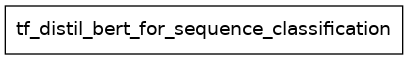

In [6]:
# view model structure
tf.keras.utils.plot_model(model)

In [7]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# save model
model.save_pretrained('sentiment_model')
tokenizer.save_pretrained('sentiment_model')

('sentiment_model/tokenizer_config.json',
 'sentiment_model/special_tokens_map.json',
 'sentiment_model/vocab.txt',
 'sentiment_model/added_tokens.json',
 'sentiment_model/tokenizer.json')

In [9]:
# 11. Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy}')

1563/1563 [==============================] - 48s 31ms/step - loss: 0.2946 - accuracy: 0.8773
Test Accuracy: 0.8772799968719482


Text(0, 0.5, 'Loss')

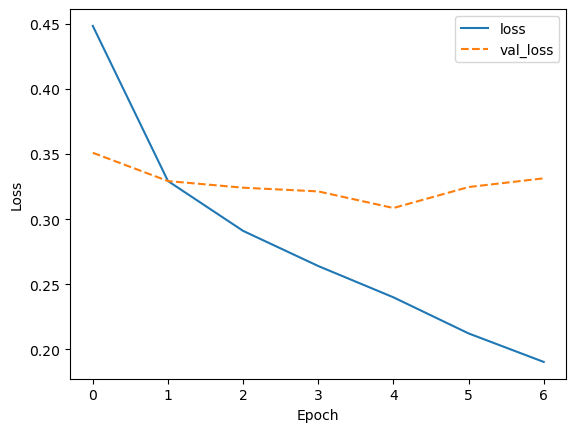

In [10]:
plt.plot(history.epoch, history.history['loss'], label='loss')
plt.plot(history.epoch, history.history['val_loss'], '--', label='val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

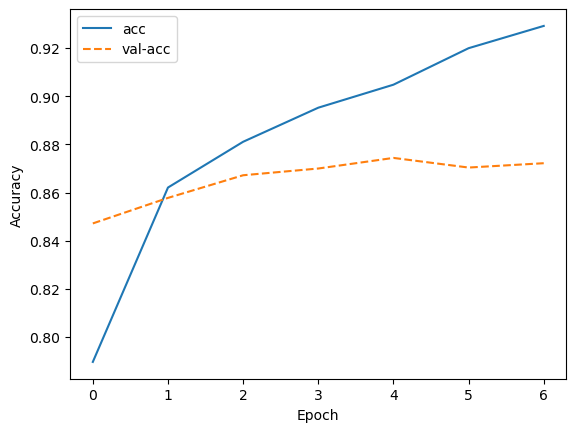

In [11]:
plt.plot(history.epoch, history.history['accuracy'], label='acc')
plt.plot(history.epoch, history.history['val_accuracy'], '--', label='val-acc')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [12]:
test_predictions = model.predict(test_encodings.data)
predicted_labels = tf.argmax(test_predictions.logits, axis=1).numpy()

782/782 [==============================] - 40s 50ms/step


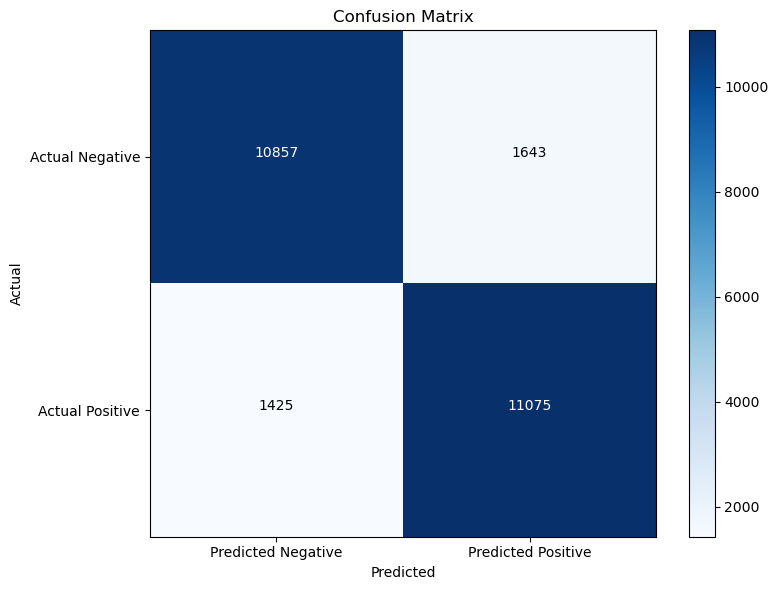

In [13]:
# Generate the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Set tick marks and labels
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted Negative', 'Predicted Positive'])
plt.yticks(tick_marks, ['Actual Negative', 'Actual Positive'])

# Loop over data dimensions and create text annotations
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [14]:
# Load the saved model and tokenizer
# model = TFDistilBertForSequenceClassification.from_pretrained('sentiment_model')
# tokenizer = DistilBertTokenizer.from_pretrained('sentiment_model')